# albumentations(画像拡張ライブラリ)を使って機械学習用に画像の加工をする

- albumentationsのダウンロードはこちらから
- https://github.com/albumentations-team/albumentations

- この記事で使用させていただいている画像はポートレートモデルの、ゆっこさん、飛緖さんです。撮影させていただきありがとうございます！

In [1]:
import albumentations as A  #albumentationsライブラリをimportする
import cv2
import matplotlib.pyplot as plt
import pandas as pd



Bad key "text.kerning_factor" on line 4 in
/Users/tt/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


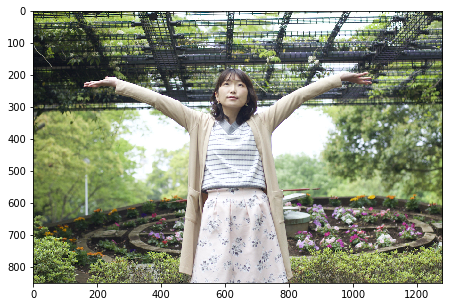

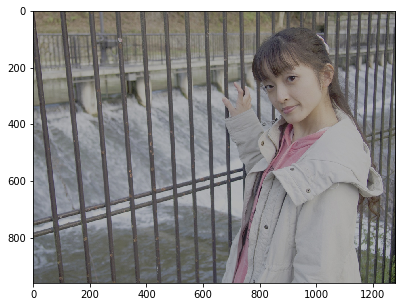

In [2]:
#この記事で使う元画像を出力してみましょう
image = cv2.imread("DSC_0897.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8, 5))
plt.imshow(image)

image = cv2.imread("file_name.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8, 5))
plt.imshow(image)

# albumentationsを使って画像を加工してみよう

In [3]:
def transform_image_plot(img_path, transform):
    #画像出力用の関数
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Augment an image
    transformed = transform(image=image)
    transformed_image = transformed["image"]
    plt.figure(figsize=(8, 5))
    plt.imshow(transformed_image);


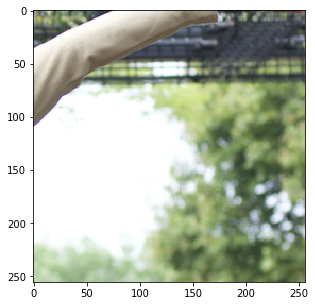

In [4]:
#写真の一部を描画しましょう
transform = A.Compose([
    A.RandomCrop(width=256, height=256),
])
transform_image_plot("DSC_0897.jpg", transform)


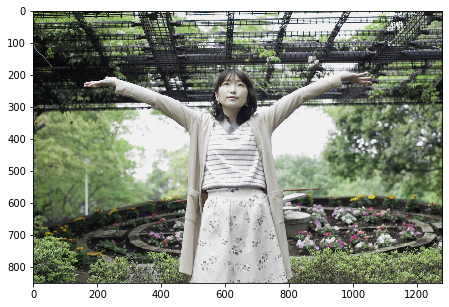

In [5]:
#入力画像の色相、彩度をランダムに変更する
transform =  A.Compose(
    [
        A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit= 20, val_shift_limit=20, p=1.0)  
    ],
    p=1.0, 
    )
transform_image_plot("DSC_0897.jpg", transform)


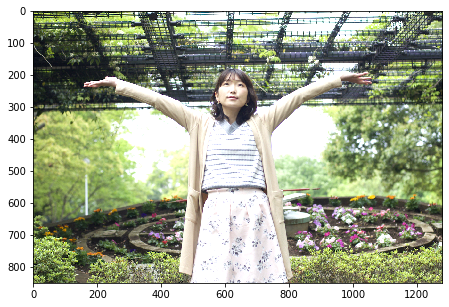

In [6]:
transform =  A.Compose(
        [
            #OneOfはどちらか一方という意味。以下の例は、HueSaturationValue、RandomBrightnessContrastのどちらかを選択するという意味
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9),
            ],p=0.9)
        ], 
        #p=1.0, 
    )
transform_image_plot("DSC_0897.jpg", transform)


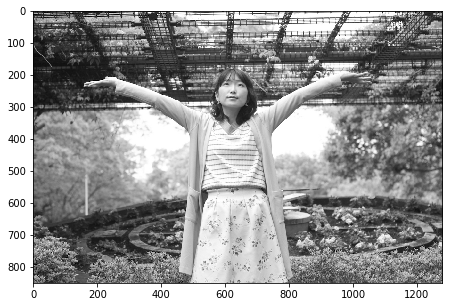

In [7]:
#グレースケースに変更する
transform =  A.Compose(
    [
        A.ToGray( p=1.0)  
    ],
    p=1.0, 
    )
transform_image_plot("DSC_0897.jpg", transform)


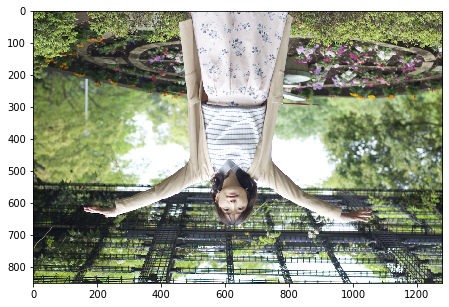

In [8]:
#上下逆さまにしてみる
transform =  A.Compose(
    [
        #HorizontalFlipは正方形の画像じゃないと動作しない？
        #A.HorizontalFlip( p=0.5),
        
        #上下逆さま
        A.VerticalFlip(p=1.0),
    ],
    p=1.0, 
    )
transform_image_plot("DSC_0897.jpg", transform)


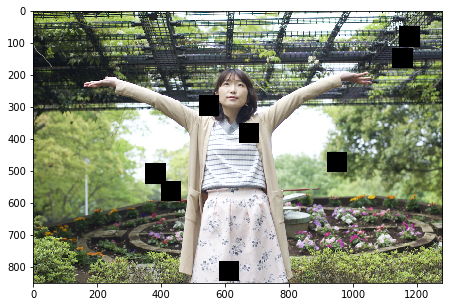

In [9]:
#黒い四角(Cutout)を入れる
transform =  A.Compose(
    [
        #黒い四角(Cutout)を入れる
        A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=1.0),
    ],
    p=1.0, 
    )
transform_image_plot("DSC_0897.jpg", transform)

In [10]:
# 機械学習のための画像拡張をする

In [11]:
from albumentations.pytorch import ToTensorV2

#画像の加工(拡張)方法を設定する
def get_train_transforms():
    return A.Compose(
        [
            A.RandomSizedCrop(min_max_height=(800, 800), height=850, width=1280, p=0.5),
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9),
            ],p=0.9),
            A.ToGray(p=0.01),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            #A.Resize(height=img_size, width=img_size, p=1),
            A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
            #ToTensorV2(p=1.0),
        ], 
        p=1.0, 
    )


In [12]:

# ====================================================
# Dataset
# ====================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset

TRAIN_PATH = "."
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['image_id'].values
        self.labels = df['label'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f'{TRAIN_PATH}/{file_name}'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            #transformは、get_train_transforms関数を呼び出すが、get_train_transformsの引数にimageが記述されていない理由は、
            #Composeクラスの__call__メソッドの引数が(self, *args, force_apply=False, **data)となっていて、以下の用に「image=image」を設定すれば
            #__call__メソッドにimageを渡すことができるからだと思われる
            #https://github.com/albumentations-team/albumentations/blob/master/albumentations/core/composition.py

            augmented = self.transform(image=image)
            image = augmented['image']
        label = torch.tensor(self.labels[idx]).long()
        return image, label
    


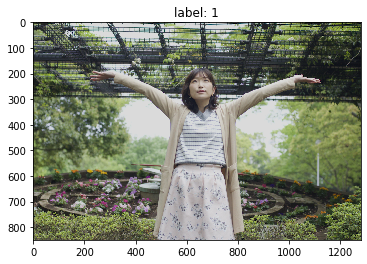

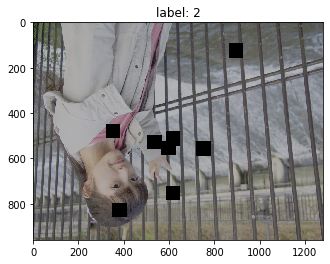

In [13]:
train = pd.read_csv('train_sample.csv')

#torch.utils.dataを使ってデータセットを作成する
train_dataset = TrainDataset(train, transform=get_train_transforms())

for i in range(len(train_dataset)):
    image, label = train_dataset[i]
    plt.imshow(image)
    plt.title(f'label: {label}')
    plt.show() 
